Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Ilsa Qadir"
COLLABORATORS = "N/A"

---

## Predicting High-Risk Covid-19 Patients and Mortality Rates

### Create Dataframe

In [ ]:
#For the github
!unzip "Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv.zip"

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv")
df.shape

(621000, 14)

### Clean Data

In [3]:
#Determine which columns have missing values
missing_values = df.isnull().sum()  #Count missing values in each column
print("Missing Values Per Column:")
print(missing_values)

Missing Values Per Column:
Data As Of                 0
Start Date                 0
End Date                   0
Group                      0
Year                   12420
Month                  62100
State                      0
Condition Group            0
Condition                  0
ICD10_codes                0
Age Group                  0
COVID-19 Deaths       183449
Number of Mentions    177577
Flag                  437551
dtype: int64


In [4]:
df_cleaned = df.copy()
#Fix Missing values in Covid-19 Deaths
#We'll assume that there were no deaths and replace the missing values with 0
df_cleaned['COVID-19 Deaths'] = df_cleaned['COVID-19 Deaths'].fillna(0)

In [5]:
#remove outliers
from scipy.stats import zscore

df_cleaned['Z-Score'] = zscore(df_cleaned['COVID-19 Deaths'])

df_no_outliers = df_cleaned[np.abs(df_cleaned['Z-Score']) < 3 ] #make 3 the threshold

#drop the column as it is no longer needed
df_no_outliers = df_no_outliers.drop(columns=['Z-Score'])
df_no_outliers.shape

(620117, 14)

### Convert Dataframe to Database

In [6]:
import sqlite3

#Create Database
db = 'my_database.db'
conn = sqlite3.connect(db)

#Create Table
og_table = 'og_table' 
df_no_outliers.to_sql(og_table, conn, if_exists='replace', index=False)

#Verify table
result = pd.read_sql_query(f"SELECT * FROM {og_table} LIMIT 5;", conn)
print("Sample Data from Original Table:")
print(result)

Sample Data from Original Table:
   Data As Of  Start Date    End Date     Group  Year Month          State  \
0  09/24/2023  01/01/2020  09/23/2023  By Total  None  None  United States   
1  09/24/2023  01/01/2020  09/23/2023  By Total  None  None  United States   
2  09/24/2023  01/01/2020  09/23/2023  By Total  None  None  United States   
3  09/24/2023  01/01/2020  09/23/2023  By Total  None  None  United States   
4  09/24/2023  01/01/2020  09/23/2023  By Total  None  None  United States   

        Condition Group                           Condition ICD10_codes  \
0  Respiratory diseases             Influenza and pneumonia     J09-J18   
1  Respiratory diseases             Influenza and pneumonia     J09-J18   
2  Respiratory diseases             Influenza and pneumonia     J09-J18   
3  Respiratory diseases  Chronic lower respiratory diseases     J40-J47   
4  Respiratory diseases  Chronic lower respiratory diseases     J40-J47   

    Age Group  COVID-19 Deaths  Number of Menti

### Create a Table with Relevant Columns

In [7]:
#Remove 'All Ages' in the Age Groups column
#Since it has all the COVID-19 deaths for a condition group, it will cause the model to be skewed.
#Also remove 'Not stated' since we don't have enough information for that category

query_2 = """ 
            DELETE FROM og_table
            WHERE "Age Group" = 'All Ages' OR "Age Group" = 'Not stated';
          """
conn.execute(query_2)
conn.commit()

In [8]:
#Create Table with Relevant Columns
#Condition Group, Age Group, and Covid-19 Deaths

query = """
        SELECT 
            "State",
            "Condition Group", 
            "Condition",
            "Age Group", 
            "COVID-19 Deaths" 
        FROM og_table; 
        """

filtered_df = pd.read_sql_query(query, conn)

new_table = "filtered_table"

filtered_df.to_sql(new_table, conn, if_exists='replace', index=False)

#Verify new table
result = pd.read_sql_query(f"SELECT * FROM {new_table} LIMIT 9;", conn)


print("Sample Data from New Table:")
print(result)

Sample Data from New Table:
           State       Condition Group                            Condition  \
0  United States  Respiratory diseases              Influenza and pneumonia   
1  United States  Respiratory diseases              Influenza and pneumonia   
2  United States  Respiratory diseases   Chronic lower respiratory diseases   
3  United States  Respiratory diseases   Chronic lower respiratory diseases   
4  United States  Respiratory diseases   Chronic lower respiratory diseases   
5  United States  Respiratory diseases   Chronic lower respiratory diseases   
6  United States  Respiratory diseases  Adult respiratory distress syndrome   
7  United States  Respiratory diseases  Adult respiratory distress syndrome   
8  United States  Respiratory diseases  Adult respiratory distress syndrome   

  Age Group  COVID-19 Deaths  
0      0-24           1569.0  
1     25-34           5804.0  
2      0-24            207.0  
3     25-34            459.0  
4     35-44           1118

## Visualize the Data

### Plot Covid-19 Death Rates based on each Condition

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Group data by 'Condition Group' and sum 'COVID-19 Deaths'
condition_deaths = filtered_df.groupby('Condition Group')['COVID-19 Deaths'].sum().reset_index()

#Determine total number of Covid-19 deaths
total_deaths = condition_deaths['COVID-19 Deaths'].sum()

#Calculate Percentage
condition_deaths['Death Percentage'] = (condition_deaths['COVID-19 Deaths'] / total_deaths) * 100

condition_deaths_sorted = condition_deaths.sort_values(by='Death Percentage', ascending=False)

#Plot data
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Death Percentage', y = 'Condition Group', data=condition_deaths_sorted)

#Set plot labels and title
plt.title('COVID-19 Deaths by Condition Group', fontsize=16)
plt.xlabel('COVID-19 Deaths (%)', fontsize=12)
plt.ylabel('Condition Group', fontsize=12)

#Show plot
plt.show()

### Plot Covid-19 Death Rates based on Age Group

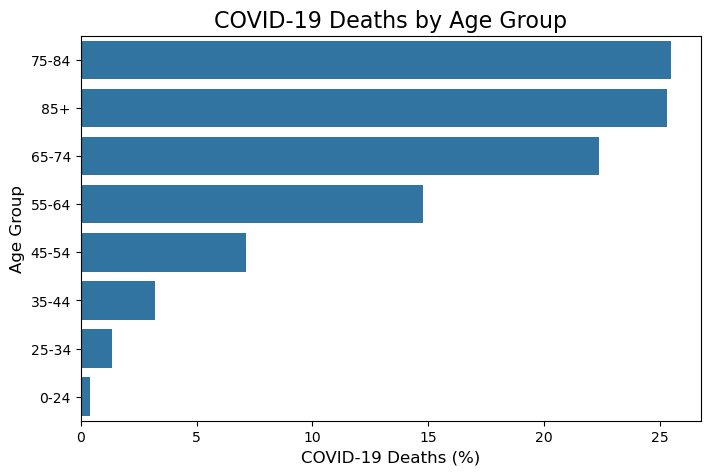

In [10]:
#Group data by 'Age Group' and sum 'COVID-19 Deaths'
age_deaths = filtered_df.groupby('Age Group')['COVID-19 Deaths'].sum().reset_index()

#Remove the 'All Ages' entry since it is unneccessary
age_deaths_filtered = age_deaths[age_deaths['Age Group'] != 'All Ages'].copy()

#Calculate the total deaths excluding 'All Ages'
total_deaths_filtered = age_deaths['COVID-19 Deaths'].sum()

#Calculate Percentage
age_deaths_filtered['Death Percentage'] = (age_deaths['COVID-19 Deaths'] / total_deaths_filtered) * 100

age_deaths_sorted = age_deaths_filtered.sort_values(by='Death Percentage', ascending=False)

#Plot data
plt.figure(figsize=(8, 5))
sns.barplot(x = 'Death Percentage', y = 'Age Group', data=age_deaths_sorted)

#Set plot labels and title
plt.title('COVID-19 Deaths by Age Group', fontsize=16)
plt.xlabel('COVID-19 Deaths (%)', fontsize=12)
plt.ylabel('Age Group', fontsize=12)

#Show plot
plt.show()

### Plot the relationship of Covid-19 Deaths by Age Groups and Condition Groups

In [ ]:
# Group data by 'Age Group', 'Condition Group' and sum 'COVID-19 Deaths'
condition_age_deaths = filtered_df.groupby(['Age Group', 'Condition Group'])['COVID-19 Deaths'].sum().reset_index()

#Remove the 'All Ages' entry since it is unneccessary
condition_age_deaths_filtered = condition_age_deaths[condition_age_deaths['Age Group'] != 'All Ages'].copy()

# Pivot the data to create a table where Age Group is on rows, Condition Group on columns, and deaths as values
pivot_data = condition_age_deaths_filtered.pivot(index='Age Group', columns='Condition Group', values='COVID-19 Deaths')

# Plot a stacked bar plot
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set labels and title
plt.title('COVID-19 Deaths by Age Group and Condition Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('COVID-19 Deaths', fontsize=12)

# Show plot

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Condition Group', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend
plt.tight_layout()  # Adjust layout for better fit

plt.show()


## Create a Model

#### Use One-Hot Encoding on Age Group, Condition Group, Condition, and State

In [12]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['State', 'Age Group', 'Condition']

encoder = OneHotEncoder(sparse_output = False)

#Encode categorical columns
encoded_data = encoder.fit_transform(filtered_df[categorical_cols])

encoded_cols = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols)

filtered_df.reset_index(drop=True, inplace=True)
encoded_df = pd.concat([filtered_df, encoded_df], axis=1)

#Drop original categorical columns
encoded_df.drop(columns = categorical_cols, inplace=True)

encoded_df.head()

,Condition Group,COVID-19 Deaths,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,...,Condition_Ischemic heart disease,Condition_Malignant neoplasms,Condition_Obesity,Condition_Other diseases of the circulatory system,Condition_Other diseases of the respiratory system,Condition_Renal failure,Condition_Respiratory arrest,Condition_Respiratory failure,Condition_Sepsis,Condition_Vascular and unspecified dementia
0,Respiratory diseases,1569.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Respiratory diseases,5804.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Respiratory diseases,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Respiratory diseases,459.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Respiratory diseases,1118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create a Random Forest Regressor Model based on States, Conditions, and Age Groups

In [13]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [14]:
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

X = encoded_df[encoded_cols]
y = encoded_df['COVID-19 Deaths']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#model = LinearRegression()
#model = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 15) 

model = XGBRegressor(n_estimators= 400, learning_rate= 0.1, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Evaluate the Model

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

#Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

#Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.4f}")

Mean Absolute Error: 42.08345026655249
Mean Squared Error: 40811.67586399645
R² score: 0.2314


### Actual COVID-19 Deaths Vs. Predicted COVID-19 Deaths

In [ ]:
plt.scatter(y_pred, y_test, label = "Actual vs Predicted", alpha=0.6)

#Line of best fit
#Use polyfit to calculate the line of best fit
coefficients = np.polyfit(y_pred, y_test, 1)
line_of_best_fit = np.polyval(coefficients, y_pred)

plt.plot(y_pred, line_of_best_fit, color='red', label="Line of Best Fit")

# Labels and title
plt.xlabel("Predicted COVID-19 Deaths")
plt.ylabel("Actual COVID-19 Deaths")
plt.title("Actual vs Predicted COVID-19 Deaths with Line of Best Fit")
plt.legend()
plt.show()

## Test the Model

In [17]:
test_cases = [
    ['New Jersey','65-74', 'Respiratory failure'],
    ['New York','75-84', 'Heart failure'],
    ['Virginia','85+', 'Diabetes']
]

test_df = pd.DataFrame(test_cases, columns = ['State','Age Group','Condition'])

test_categorical_cols = ['State', 'Age Group', 'Condition']

test_encoder = OneHotEncoder(sparse_output = False, drop = 'first')

test_encoded_data = encoder.fit_transform(test_df[test_categorical_cols])

test_encoded_cols = encoder.get_feature_names_out(test_categorical_cols)
test_encoded_df = pd.DataFrame(test_encoded_data, columns=test_encoded_cols)

for col in X.columns:
    if col not in test_encoded_df.columns:
        test_encoded_df[col] = 0

test_encoded_df = test_encoded_df[X.columns]
test_scaled = scaler.transform(test_encoded_df)

death_predictions = model.predict(test_scaled)
results_df = pd.DataFrame(test_cases, columns = ['State','Age Group', 'Condition'])
results_df['Predicted Deaths'] = death_predictions

print(results_df)

        State Age Group            Condition  Predicted Deaths
0  New Jersey     65-74  Respiratory failure        125.371330
1    New York     75-84        Heart failure         56.581532
2    Virginia       85+             Diabetes         35.221424


### Calculate Mortality Rate for Covid-19

In [18]:
total_deaths_per_group = filtered_df.groupby(['State','Age Group','Condition'])['COVID-19 Deaths'].sum().reset_index()

merged_results = pd.merge(results_df, total_deaths_per_group, on = ['State','Age Group', 'Condition'], how='left')
merged_results.rename(columns={'COVID-19 Deaths': 'Total Deaths'}, inplace=True)

#Calculate the percentage of deaths
merged_results['Mortality Rate'] = (merged_results['Predicted Deaths'] / merged_results['Total Deaths']) * 100

merged_results[['Age Group', 'Condition', 'Predicted Deaths', 'Total Deaths', 'Mortality Rate']]

,Age Group,Condition,Predicted Deaths,Total Deaths,Mortality Rate
0,65-74,Respiratory failure,125.371330,10721.0,1.169400
1,75-84,Heart failure,56.581532,2347.0,2.410802
2,85+,Diabetes,35.221424,1386.0,2.541228
